# Croissant 🥐 Online Health Report

## Example of [OpenML](https://www.openml.org)

This notebook is based on the output produced after crawling [openml.org](https://www.openml.org). See the README for more details.

At the moment, we only crawl Hugging Face which is why the report is custom for Hugging Face. We will enrich other repositories in the future (Kaggle, OpenML). The goal here is to make the Croissant ecosystem better by analyzing issues.

In [1]:
import sys

from etils import epath
from IPython.display import Markdown
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns

sns.set()

source = "openml"  # Name of the scrapy spider

folder = epath.Path(sys.path[0]) / "../data"
files = folder.glob("*/*.parquet")
df = pl.scan_parquet(files).filter(pl.col("source") == source)

print(f"Report for {source}")

Report for openml


## 1. Responses overview

Scrapped 5430 datasets for openml

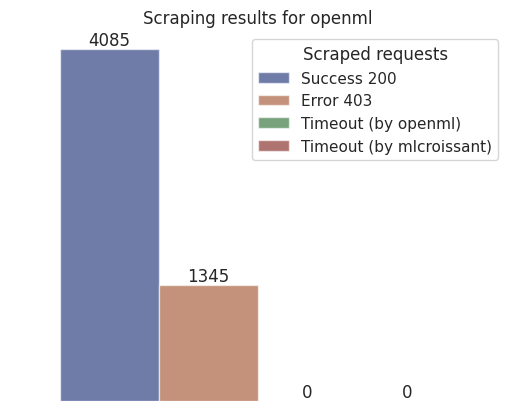

In [2]:
sns.set_style("white")

num_rows = df.select(pl.len()).collect().item()
display(Markdown(f"Scrapped {num_rows} datasets for {source}"))

has_timeout = pl.col("timeout_seconds").is_not_null()
has_croissant_timeout = pl.col("croissant_timeout_seconds").is_not_null()
data = df.filter(~has_timeout & ~has_croissant_timeout).group_by(pl.col("response_status")).len().sort(by="len", descending=True).collect()
num_timeouts = df.filter(has_timeout & ~has_croissant_timeout).select(pl.len()).collect().item()
num_croissant_timeouts = df.filter(~has_timeout & has_croissant_timeout).select(pl.len()).collect().item()
labels = [f"Success {code}" if code == 200 else f"Error {code}" for code in data["response_status"]] + [f"Timeout (by {source})"] + ["Timeout (by mlcroissant)"]
data = list(data["len"]) + [num_timeouts] + [num_croissant_timeouts]
data = {'Scraped requests': labels, 'Number': data}
hue_order = [element[1] for element in sorted(zip(data["Number"], data["Scraped requests"]), reverse=True)]
ax = sns.barplot(y='Number', hue='Scraped requests', data=data, palette="dark", alpha=.6, hue_order=hue_order)
ax.set(yticklabels=[])
ax.set(ylabel=None)
for i in ax.containers:
    ax.bar_label(i,)
plt.title(f"Scraping results for {source}")
sns.despine(left=True, bottom=True)
plt.show()

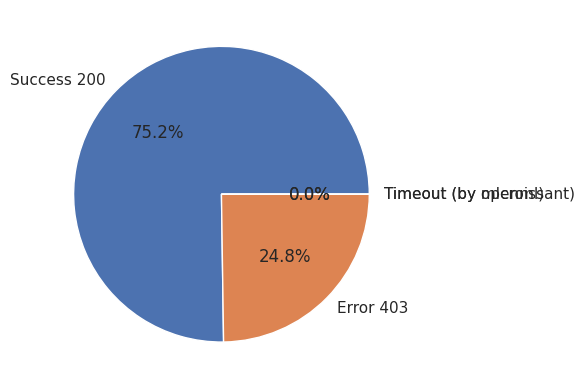

In [3]:
plt.pie(data["Number"], labels=data["Scraped requests"], autopct='%1.1f%%')
plt.show()

## 2. Croissant statistics

For the moment, we only count the number of `cr:Field`, `cr:RecordSet`, etc. We will enrich with more signals in the future.

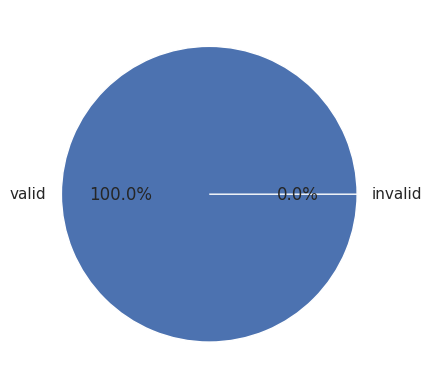

In [4]:
data = df.filter(pl.col("response_status") == 200)
valid = data.filter(pl.col("croissant_is_valid")).select(pl.len()).collect().item()
invalid = data.filter(~pl.col("croissant_is_valid")).select(pl.len()).collect().item()
plt.pie([valid, invalid], labels=["valid", "invalid"], autopct='%1.1f%%')
plt.show()

In [5]:
columns = [
    "croissant_num_fields",
    "croissant_num_file_objects",
    "croissant_num_file_sets",
    "croissant_num_record_sets",
]
for column in columns:
    display(df.select(pl.col(column)).collect().describe(percentiles=[]))

statistic,croissant_num_fields
str,f64
"""count""",4085.0
"""null_count""",1345.0
"""mean""",28.686659
"""std""",33.503537
"""min""",0.0
"""max""",243.0


statistic,croissant_num_file_objects
str,f64
"""count""",4085.0
"""null_count""",1345.0
"""mean""",1.0
"""std""",0.0
"""min""",1.0
"""max""",1.0


statistic,croissant_num_file_sets
str,f64
"""count""",4085.0
"""null_count""",1345.0
"""mean""",0.0
"""std""",0.0
"""min""",0.0
"""max""",0.0


statistic,croissant_num_record_sets
str,f64
"""count""",4085.0
"""null_count""",1345.0
"""mean""",3.781885
"""std""",8.181862
"""min""",1.0
"""max""",118.0


In [6]:
# Report by type of errors

data = df.select(pl.col("croissant_errors")).collect()
display(Markdown(f"#### Croissant errors"))
i = 0
for row in data.rows(named=True):
    for error in row["croissant_errors"]:
        if i > 100:
            break
        display(Markdown(f"- {error}"))
        i += 1
if i == 0:
    display(Markdown("None"))

#### Croissant errors

None

## 3. In-depth errors

We now try to deep dive into the errors to understand why it fails.

In [7]:
# Report by type of errors

# List of errors that we currently know
CURRENTLY_KNOWN_ERRORS = []

rows_with_errors = ~has_timeout & ~has_croissant_timeout & pl.col("response_status") != 200
data = df.filter(rows_with_errors).group_by(pl.col("response_status")).agg(pl.col("body")).collect()
for row in data.rows(named=True):
    if row["response_status"] != 200:
        display(Markdown(f"### Status {row['response_status']}"))
        known_errors, unknown_errors = [], []
        for error in row["body"]:
            error = error.decode()
            if any(error.startswith(known_error) for known_error in CURRENTLY_KNOWN_ERRORS):
                known_errors.append(error)
            else:
                unknown_errors.append(error)
        if known_errors:
            display(Markdown(f"#### Known errors"))
            for error in known_errors[:10]:
                display(Markdown(f"- {error}"))
        if unknown_errors:
            display(Markdown(f"#### Unknown errors"))
            for error in unknown_errors[:10]:
                display(Markdown(f"- {error}"))

### Status 403

#### Unknown errors

- <?xml version="1.0" encoding="UTF-8"?>
<Error><Code>AccessDenied</Code><Message>Access Denied.</Message><Key>croissant.json</Key><BucketName>dataset42476</BucketName><Resource>/dataset42476/croissant.json</Resource><RequestId>17B5E3CEA5E910EE</RequestId><HostId>777dd3170fb525141b6815a043d32d4d30924379f24afda59c4c681c653f052f</HostId></Error>

- <?xml version="1.0" encoding="UTF-8"?>
<Error><Code>AccessDenied</Code><Message>Access Denied.</Message><Key>croissant.json</Key><BucketName>dataset42564</BucketName><Resource>/dataset42564/croissant.json</Resource><RequestId>17B5E3CF0431CA0F</RequestId><HostId>56c44e740833ad0b0ac088d06a46ffbdfed07b46a072585e0976c0259055519a</HostId></Error>

- <?xml version="1.0" encoding="UTF-8"?>
<Error><Code>AccessDenied</Code><Message>Access Denied.</Message><Key>croissant.json</Key><BucketName>dataset42647</BucketName><Resource>/dataset42647/croissant.json</Resource><RequestId>17B5E3CFB768412A</RequestId><HostId>56c44e740833ad0b0ac088d06a46ffbdfed07b46a072585e0976c0259055519a</HostId></Error>

- <?xml version="1.0" encoding="UTF-8"?>
<Error><Code>AccessDenied</Code><Message>Access Denied.</Message><Key>croissant.json</Key><BucketName>dataset42708</BucketName><Resource>/dataset42708/croissant.json</Resource><RequestId>17B5E3CFFFC89E69</RequestId><HostId>1592b494b367d3602e5a400a9dc2ba37d7fc3add1b540aa2fa228ece43739d2f</HostId></Error>

- <?xml version="1.0" encoding="UTF-8"?>
<Error><Code>AccessDenied</Code><Message>Access Denied.</Message><Key>croissant.json</Key><BucketName>dataset42824</BucketName><Resource>/dataset42824/croissant.json</Resource><RequestId>17B5E3D0C881AA2B</RequestId><HostId>b539e285fa29bf61d877d45074ae06507bc2cb4545c54bc7fb4b7d5f3f1cf1c6</HostId></Error>

- <?xml version="1.0" encoding="UTF-8"?>
<Error><Code>AccessDenied</Code><Message>Access Denied.</Message><Key>croissant.json</Key><BucketName>dataset42874</BucketName><Resource>/dataset42874/croissant.json</Resource><RequestId>17B5E3D15FEDC11D</RequestId><HostId>56c44e740833ad0b0ac088d06a46ffbdfed07b46a072585e0976c0259055519a</HostId></Error>

- <?xml version="1.0" encoding="UTF-8"?>
<Error><Code>AccessDenied</Code><Message>Access Denied.</Message><Key>croissant.json</Key><BucketName>dataset42875</BucketName><Resource>/dataset42875/croissant.json</Resource><RequestId>17B5E3D161BBCF46</RequestId><HostId>b539e285fa29bf61d877d45074ae06507bc2cb4545c54bc7fb4b7d5f3f1cf1c6</HostId></Error>

- <?xml version="1.0" encoding="UTF-8"?>
<Error><Code>AccessDenied</Code><Message>Access Denied.</Message><Key>croissant.json</Key><BucketName>dataset42979</BucketName><Resource>/dataset42979/croissant.json</Resource><RequestId>17B5E3D211740670</RequestId><HostId>b539e285fa29bf61d877d45074ae06507bc2cb4545c54bc7fb4b7d5f3f1cf1c6</HostId></Error>

- <?xml version="1.0" encoding="UTF-8"?>
<Error><Code>AccessDenied</Code><Message>Access Denied.</Message><Key>croissant.json</Key><BucketName>dataset42980</BucketName><Resource>/dataset42980/croissant.json</Resource><RequestId>17B5E3D2139BEA72</RequestId><HostId>56c44e740833ad0b0ac088d06a46ffbdfed07b46a072585e0976c0259055519a</HostId></Error>

- <?xml version="1.0" encoding="UTF-8"?>
<Error><Code>AccessDenied</Code><Message>Access Denied.</Message><Key>croissant.json</Key><BucketName>dataset42981</BucketName><Resource>/dataset42981/croissant.json</Resource><RequestId>17B5E3D215A398A1</RequestId><HostId>777dd3170fb525141b6815a043d32d4d30924379f24afda59c4c681c653f052f</HostId></Error>

In [8]:
# Report by occurrence

rows_with_errors = ~has_timeout & ~has_croissant_timeout & pl.col("response_status") != 200
data = df.filter(rows_with_errors).group_by([pl.col("response_status"), pl.col("body")]).len().sort(by="len", descending=True).collect()

errors = data.filter(pl.col("response_status") != 200)
for error in errors.rows(named=True):
    if error["len"] > 5:
        display(Markdown(f"- **[{error['len']} similar errors]** [code {error['response_status']}]: {error['body'].decode()[:1000]}"))